# Setup

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

In [ ]:
!mamba  install  -q -y -c rapidsai -c conda-forge -c nvidia cucim cuml #cupy
!git clone https://github.com/danionella/hoffmann_et_al_2023.git
!pip install --ignore-installed  --quiet ./hoffmann_et_al_2023
!wget "https://owncloud.charite.de/owncloud/index.php/s/zc9NTVJMw8AiuQn/download?path=%2F&files=20230611_export_3.h5" -O data.h5

# Analysis

## Run in any case

In [18]:
import h5py as h5
import numpy as np
from tqdm.auto import tqdm
from wholebrain import util,cluster,spatial,regression,stats
from matplotlib import pyplot as plt
import xarray as xr
import os
import matplotlib
import cupy as cp
from scipy.stats import pearsonr
from scipy.optimize import minimize

c_voxel="#3B7BBF"
c_random='#F9A91C'
c_pca='#ED1B50'


def binfcn(x):
    return np.nanmean(x), np.quantile(x,0.05), np.quantile(x,0.95)

def load_dset(name):
    with h5.File('./data.h5','r') as fh5:
        return fh5[name]['coords'][:],fh5[name]['dff'][:],fh5[name]['traces'][:]

In [2]:
data={}
with h5.File('./data.h5','r') as fh5:
    names=[n for n in fh5.keys()]
    print('Datasets:', names)
   
p_out='tmp'
os.makedirs(os.path.join('./',p_out),exist_ok=True)

Datasets: ['dset_0', 'dset_1', 'dset_2', 'dset_3', 'dset_4', 'dset_5']


## Figure 3

In [3]:
pars={"corr_fc":
     { "min_dist":400, 
      "radius_list": [5,10,15,25,50,100,150,200], 
      "save_full_at":[5,50,100,200],
      "dec_factor":20}
     } 

In [4]:
name=names[0] #Select Dataset 
coords,dff,traces=load_dset(name)
dff_mu=(dff-np.nanmean(dff,0,keepdims=True))[~np.isnan(dff.sum(1))] # Centered Data without NANs ( motion)

Compute pairwise correlations, pairwise distances and pairwise correlations of macro-voxels

In [5]:

fh5_l = h5.File(os.path.join(p_out, f"{name}_correlations.h5"), "w")
cc = stats.corrx(cp.array(dff_mu,'single'), cp.array(dff_mu,'single'))
pd = spatial.pdist(cp.array(coords,'single'), None)
fh5_l["ipsi_cc"], fh5_l["contra_cc"] = util.neighbourhood_correlation(
    coords, cc.get())
fh5_l["cc"] = cc.get()
fh5_l["pd"] = pd.get()
del cc,pd

 
fh5_l["fc_before"], fh5_l["fc_corr_mean"], fh5_l["fc_after"] = util.corr_fc( fh5_l["cc"][:], fh5_l["pd"][:], cp.array(dff_mu,'single'), **pars["corr_fc"])
fh5_l.close()


/home/hoffmmax/repos/hoffmann_et_al_2023/src/wholebrain/util.py:92: RuntimeWarning: invalid value encountered in divide
  ipsi_cc = np.sum((cc * mask_ipsi), axis=axis) / np.sum(mask_ipsi, axis=axis)
/home/hoffmmax/repos/hoffmann_et_al_2023/src/wholebrain/util.py:93: RuntimeWarning: invalid value encountered in divide
  contra_cc = np.sum((cc * mask_contra), axis=axis) / np.sum(mask_contra, axis=axis)
100%|████████████████████████████████████████████████████████████| 8/8 [01:07<00:00,  8.39s/it]


Load data and compute histrogram values

In [6]:
n_step=50
dist_bins = np.r_[10:1000:5]
binstats_list=[]

with h5.File(os.path.join(p_out, f"{name}_correlations.h5"),'r') as fh5:
    cc=fh5['cc'][:]
    pd=fh5['pd'][:]
    contra_cc=fh5['contra_cc'][:]
    ipsi_cc=fh5['ipsi_cc'][:]
    binstats = util.apply_to_bins(pd.ravel()[::n_step], dist_bins, cc.ravel()[::n_step], binfcn)
    binstats_list.append(binstats)
    print(fh5.keys())

100%|███████████████████████████████████████████████████████| 197/197 [00:00<00:00, 244.46it/s]

<KeysViewHDF5 ['cc', 'contra_cc', 'fc_after', 'fc_before', 'fc_corr_mean', 'ipsi_cc', 'pd']>


### Figure 3a

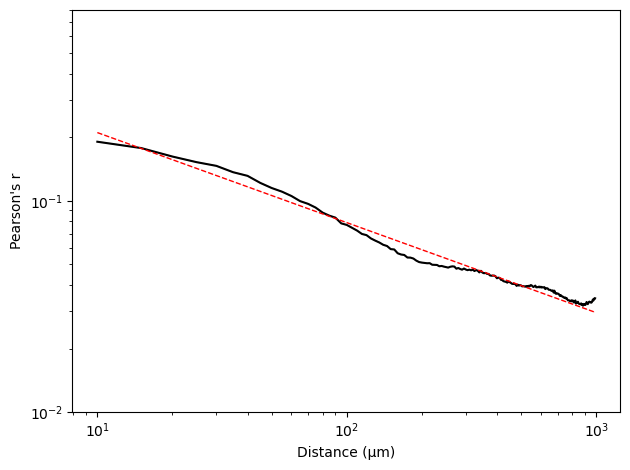

In [7]:
fig, ax = plt.subplots()
bin_ar=np.array(binstats_list)[:,:,0]
for ii,binstats in enumerate(binstats_list):
        xx=dist_bins[: - 1]
        yy=binstats[:, 0]
        powlaw= lambda x,a,k: a*xx**(k)
        mse= lambda a: np.sum((powlaw(xx,a[0],a[1])-yy)**2)
        a=minimize(mse,[yy.max(),-1])
        ax.plot(xx, yy, label=names[ii],c='k',lw=1,alpha=0.2)
        ax.plot(xx, powlaw(xx,*a.x).squeeze(),'--',c='r',lw=0.5,label='fit',alpha=0.2)
 
powlaw= lambda x,a,k: a*xx**(k)
yy=bin_ar.mean(0)
ax.plot(xx,yy,c='k') 
mse= lambda a: np.sum((powlaw(xx,a[0],a[1])-yy)**2)
a=minimize(mse,[yy.max(),-1])
ax.plot(xx, powlaw(xx,*a.x).squeeze(),'--',c='r',lw=1,label='fit')

    #ax.fill_between(dist_bins[1: - 1], binstats[1:, 1], binstats[1:, 2], label='5%-95%')
ax.set_ylim(0.01, 0.8)
#ax.set_xlim(None, 1500)
#ax.set_xticks((0,0.1,0.2,0.4))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Distance (µm)')
ax.set_ylabel("Pearson's r")
plt.tight_layout()


### Figure 3e

100%|████████████████████████████████████████████████████████████| 4/4 [00:51<00:00, 12.80s/it]


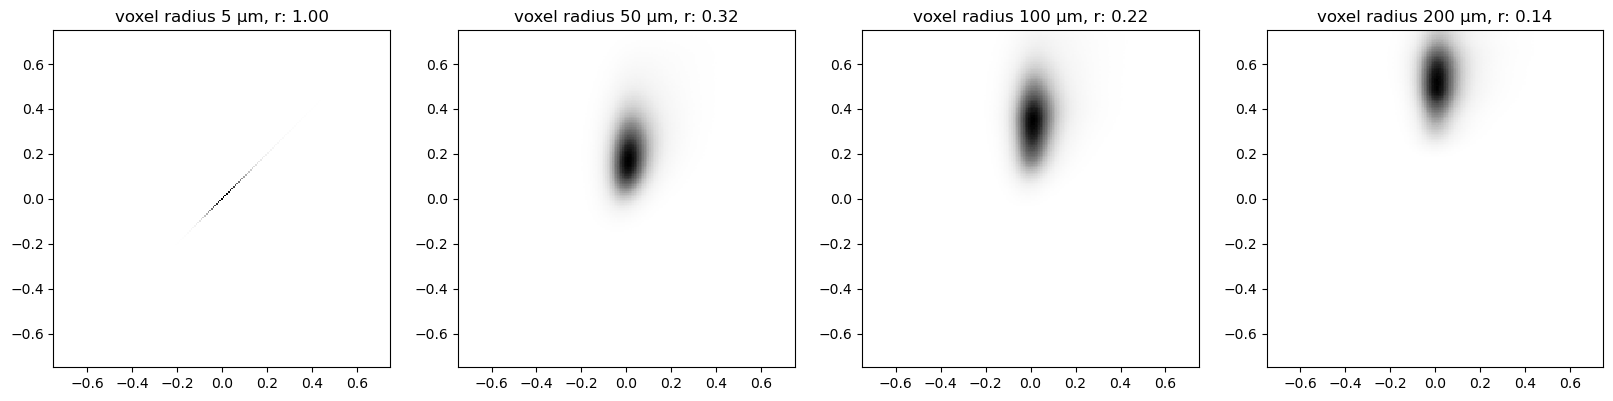

In [8]:
fig,axi=plt.subplots(1,4,figsize=[20,20])
with h5.File(os.path.join(p_out, f"{name}_correlations.h5"),'r') as fh5:
    for ii, s in enumerate(tqdm(pars['corr_fc']['save_full_at'])):
        x=fh5['fc_after'][ii]
        y=fh5['fc_before']
        r = pearsonr(x[~np.isnan(x)],y[~np.isnan(x)])
        axi[ii].hist2d(y, x,  bins=np.linspace(-.75,.75,200), cmap='Greys',rasterized=True);
        axi[ii].set_aspect('equal', 'box')
        ix=pars['corr_fc']['radius_list'].index(s)
        r_lbl=fh5['fc_corr_mean'][ix,0]
        axi[ii].set_title(f'voxel radius {s} µm, r: {r_lbl:.2f}')


### Figure 3f

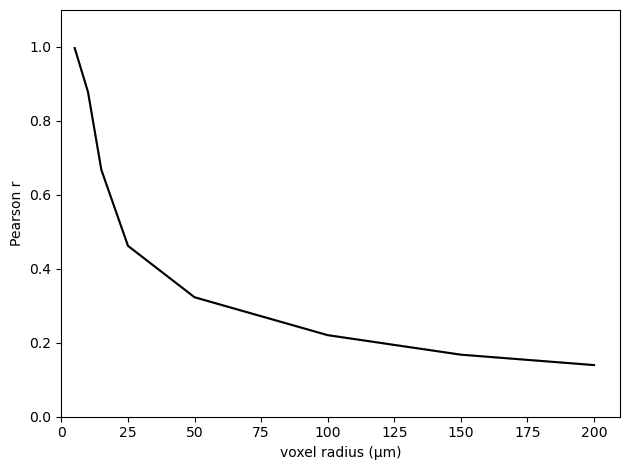

In [9]:
fig,ax=plt.subplots()
fc_l=[]



with h5.File(os.path.join(p_out, f"{name}_correlations.h5"),'r') as fh5:
        _=ax.plot(pars["corr_fc"]["radius_list"],fh5['fc_corr_mean'],label=name,c='k',alpha=0.2)
        fc_l.append(fh5['fc_corr_mean'][:])
ax.plot(pars['corr_fc']['radius_list'],np.array(fc_l).mean(0),'k',ls='-')
_=ax.set(xlim=(0,None), ylim=(0,1.1), xlabel='voxel radius (µm)', ylabel='Pearson r')
plt.tight_layout()


## Figure 4

In [10]:
n_repeats=3
alpha_repeats=3

pars={"global": {"stripe_period":300,
                 "val_fraction":0.2,
                 "test_fraction":0.2,
                 "target_fraction":0.1,
                 "alphas":np.geomspace(1,10000,20).tolist(),
                "alpha_repeats":alpha_repeats
             },
 "pca_reg": 
 { "dims_list":np.geomspace(1, 1500, 200).tolist(),"n_repeats":n_repeats},
 "random_predictors": 
 { "n_pred_list": [100,200,400,1000,2000,5000,10000,20000],"n_repeats":n_repeats},
 "voxelate":
 {"s_bins_dim": [5,10,25,50,100,150,200,500],"n_pred_list": [100,200,400,1000,2000,5000,10000,20000],"n_repeats":n_repeats},
"r2_scan":{"s_bins":[5,10,25,50,100,150,200,500],"n_pred_list": [100,200,400,1000,2000,5000,10000,20000],"alphas":np.geomspace(1,10000,20).tolist(),"n_repeats":n_repeats},
     }

In [11]:
coords,dff,traces=load_dset(names[0]) #Choose dataset
dff_mu=(dff-np.nanmean(dff,0,keepdims=True))[~np.isnan(dff.sum(1)),:] # Centered Data without NANs ( motion)

In [12]:
cv_train,cv_val,cv_test=util.create_crossvalidation_mask(dff_mu)
n_targets = int(dff_mu.shape[1] * pars["global"]["target_fraction"])
max_npred=(1-pars['global']['target_fraction'])*dff_mu.shape[1]

### Figure 4b,c

#### Bi-crossvalidated PCA

In [13]:
r2_bcvpca = util.pca_run(dff_mu, cv_test + cv_train,pars["pca_reg"]["dims_list"],n_targets=n_targets, n_repeats=pars["pca_reg"]["n_repeats"],)


100%|████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.00s/it]


#### Determination of regularization parameter for ridge regression

In [14]:
print("Alpha Scan for regression")
   
alphas=pars["global"]["alphas"]
r2_l=[]
s_bin=pars["voxelate"]["s_bins_dim"]

for alpha in alphas:
        nnz, r2_voxelate = util.voxelate_regression(
            [s_bin[len(s_bin)//2]],
            dff_mu,
            coords,
            cv_test,
            n_targets=n_targets,
            n_repeats=pars["global"]["alpha_repeats"],
            alpha=alpha,
        )
        r2_l.append(r2_voxelate.mean()) 
        
#Update global alpha parameter
pars["global"]["alpha"]=alphas[np.argmax(r2_l)]

Alpha Scan for regression


100%|████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]


#### Voxelized regression with determined alpha parameter


In [15]:
nnz, r2_voxelate = util.voxelate_regression(
    pars["voxelate"]["s_bins_dim"],
    dff_mu,
    coords,
    cv_test + cv_train,
    n_targets=n_targets,
    n_repeats=pars["voxelate"]["n_repeats"],
    alpha=pars["global"]["alpha"],
)
       


 38%|██████████████████████▌                                     | 3/8 [00:15<00:23,  4.75s/it]/home/hoffmmax/repos/hoffmann_et_al_2023/src/wholebrain/regression.py:85: RuntimeWarning: invalid value encountered in matmul
  XtXa = (X.T @ X) + xp.eye(X.shape[1]) * alpha

100%|████████████████████████████████████████████████████████████| 3/3 [00:52<00:00, 17.66s/it]


#### Random predictors with determined alpha parameter

In [16]:

r2_rand_pred = util.ridge_random(
    dff_mu,
    pars["random_predictors"]["n_pred_list"],
    cv_test + cv_train,
    n_repeats=pars["random_predictors"]["n_repeats"],
    alpha=pars["global"]["alpha"],
    n_targets=n_targets,
)


100%|████████████████████████████████████████████████████████████| 3/3 [00:23<00:00,  7.90s/it]


#### Figure panels

NameError: name 'c_pca' is not defined

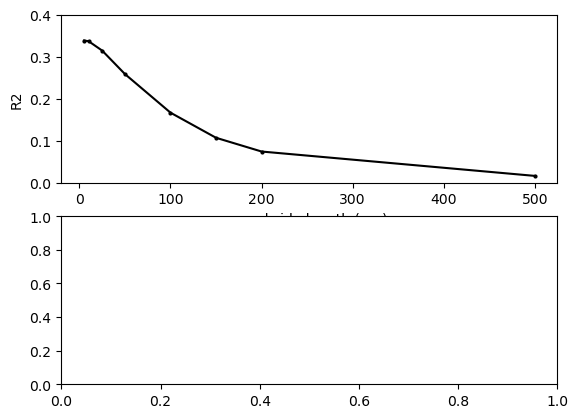

In [17]:
fig,ax=plt.subplots(2,1)
ms=2
lw=1
ax[0].plot(r2_voxelate.voxelsize,r2_voxelate.mean('n_repeats'), '-',color='k',marker='o',markersize=ms)
ax[0].set(xlabel='voxel side length (µm)', ylabel='R2')
ax[0].set_xticks(np.arange(0,600,100))
ax[0].set_ylim(0,0.4)
ax[1].plot(np.floor(r2_bcvpca.dimensions)[::5],r2_bcvpca.mean('n_repeats')[::5],color=c_pca,linestyle='-',marker='o',markersize=ms,alpha=1,lw=lw)
ax[1].fill_between(np.floor(r2_bcvpca.dimensions),r2_bcvpca.quantile(0.05,'n_repeats'),r2_bcvpca.quantile(0.95,'n_repeats'),alpha=0.3,color=c_pca,lw=0.01, label='PCs')


ax[1].plot(r2_rand_pred.n_predictors,r2_rand_pred.mean('n_repeats'),color=c_random,linestyle='-',marker='o',markersize=ms,alpha=1,lw=lw)
ax[1].fill_between(r2_rand_pred.n_predictors,r2_rand_pred.quantile(0.05,'n_repeats'),r2_rand_pred.quantile(0.95,'n_repeats'),alpha=0.3,color=c_random,lw=0.01, label='cells')

ax[1].plot(nnz.mean('n_repeats'),r2_voxelate.mean('n_repeats'),c=c_voxel,linestyle='-',marker='o',markersize=ms,alpha=1,lw=lw)
ax[1].fill_between(nnz.mean('n_repeats'),r2_voxelate.quantile(0.05,'n_repeats'),r2_voxelate.quantile(0.95,'n_repeats'),alpha=0.3,color=c_voxel,lw=0.01, label='voxels')


ax[1].set_xscale('log')
ax[1].set_xlabel('Number of predictors')
ax[1].set_ylabel('R2')
ax[1].legend()
ax[1].set_xticks([10**x for x in range(0,6)])
ax[1].set_ylim(0,0.4)
ax[1].set_xlim(0,None)
plt.tight_layout()

### Figure 4d

#### De-coupling R2 and voxelsize (Duration ~ 40 mins)

In [ ]:
R2s = util.voxelate_alpha_scan(
        pars["r2_scan"]["s_bins"],
        pars["r2_scan"]["n_pred_list"],
        coords,
        dff_mu,
        cv_test,
        cv_train,
        pars["r2_scan"]["alphas"],
        n_repeats=pars["global"]["alpha_repeats"],
        n_targets=n_targets,
    )
alphas_max = R2s.mean("repeats").idxmax("alphas")

R2s_val, batch_id = util.voxelate_all(
    pars["r2_scan"]["s_bins"],
    pars["r2_scan"]["n_pred_list"],
    coords,
    dff_mu,
    cv_train + cv_test,
    alphas_max,
    n_repeats=pars["r2_scan"]["n_repeats"],
    n_targets=n_targets,
)


#### Figure panel

In [ ]:
##### R2 Plot


opac=0.1
var=xr.DataArray(dff_mu[cv_val].var(0),dims='cells')
fig,ax=plt.subplots()
for nn in R2s_val.num_predictors:
    color = next(ax._get_lines.prop_cycler)['color']
    vox_list=[]
    for vx_sz in R2s_val.voxel_size:
        batch_means=[]
        for irep in R2s_val.repeats:
            arr=batch_id[0].sel(num_predictors=nn).isel(repeats=irep).sel(voxel_size=vx_sz)
            arr_r2=R2s_val[0].sel(num_predictors=nn).isel(repeats=irep).sel(voxel_size=vx_sz)

            batch_nr,indx=np.unique(arr,return_inverse=True)

            for ii in range(max(indx)):
                batch_mask=(indx==ii)
                batch_means.append(np.average(arr_r2[batch_mask],weights=var[batch_mask]))
        vox_list.append(batch_means)

    ax.plot(R2s_val.voxel_size,[np.nanmean(x) for x in vox_list],ls='-',c=color,label=f'{int(nn)}')
    ax.fill_between(R2s_val.voxel_size,[np.nanpercentile(x,95) for x in vox_list],[np.nanpercentile(x,5) for x in vox_list],alpha=opac,color=color,lw=0.01)

    vox_list=[]
    for vx_sz in R2s_val.voxel_size:
        batch_means=[]
        for irep in R2s_val.repeats:
            arr=batch_id[1].sel(num_predictors=nn).isel(repeats=irep).sel(voxel_size=vx_sz)
            arr_r2=R2s_val[1].sel(num_predictors=nn).isel(repeats=irep).sel(voxel_size=vx_sz)

            batch_nr,indx=np.unique(arr,return_inverse=True)

            for ii in range(max(indx)):
                batch_mask=(indx==ii)
                batch_means.append(np.average(arr_r2[batch_mask],weights=var[batch_mask]))
        vox_list.append(batch_means)

    ax.plot(R2s_val.voxel_size,[np.nanmean(x) for x in vox_list],ls='--',c=color, label='')
    ax.fill_between(R2s_val.voxel_size,[np.nanpercentile(x,95) for x in vox_list],[np.nanpercentile(x,5) for x in vox_list],alpha=opac,color=color,lw=0.01)#,hatch="*")
ax.set_ylim(0,0.5)
plt.plot([], [],' ',ls='--', label="shuffled")
ax.legend(ncol=2,loc='upper right')
ax.set(xlabel='voxel side length (µm)', ylabel='R2')

## Figure 5

In [ ]:
n_repeats = 25
pred_list = [50,100,200,400,1000,2000]
voxel_size_list = [50,100,200]
metrics = ['similarity', 'distortion']

out = np.ones((len(names), len(metrics), len(pred_list), len(voxel_size_list), n_repeats, 2)) * np.nan
        
for k_ds, name in enumerate(tqdm(names, position=0, leave=True)):
    
    coords,dff,traces=load_dset(name)
    dff_mu=(dff-np.nanmean(dff,0,keepdims=True))[~np.isnan(dff.sum(1))] # Centered Data without NANs ( motion)
   
   
    randperm = np.random.permutation(np.arange(len(coords)))
    dff_mu = dff_mu[:,randperm]
    coords = coords[randperm]


    cell_mask = np.zeros(len(coords), dtype='bool')
    cell_mask[::2] = True
    
    for k_metric, metric in enumerate(metrics):
        if metric == 'similarity':
            def distortion_stress(D0, D):
                return stats.pearsonr.gpu(D0.ravel(),D.ravel())[0]
            def distance_fun(x):
                return 1-stats.corrx.gpu(x.T,x.T)
        elif metric == 'distortion':
            def distortion_stress(D0, D):
                return spatial.distortion_stress(D0,D)
            def distance_fun(x):
                return spatial.pdist.gpu(x)
        
        D0 = distance_fun(dff_mu[:,cell_mask])

        for k_vx, voxel_size in enumerate(voxel_size_list):
            for k_pred, n_pred in enumerate(pred_list):
                for k in range(n_repeats):
                    cell_sub = dff_mu[:,np.random.choice(np.where(~cell_mask)[0], size=n_pred, replace=False)]
                    dd_cell = distortion_stress(D0,distance_fun(cell_sub))
                    vox_sub = spatial.voxelate(coords[~cell_mask] + np.random.rand(1,3)*voxel_size, dff_mu[:,~cell_mask], voxel_size, average=True)[0]
                    if vox_sub.shape[1] < n_pred: continue
                    vox_sub = vox_sub[:,np.random.choice(np.arange(vox_sub.shape[1]), size=n_pred, replace=False)]
                    dd_vox = distortion_stress(D0,distance_fun(vox_sub))
                    out[k_ds,k_metric,k_pred,k_vx,k,:] = [dd_cell, dd_vox]

